In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

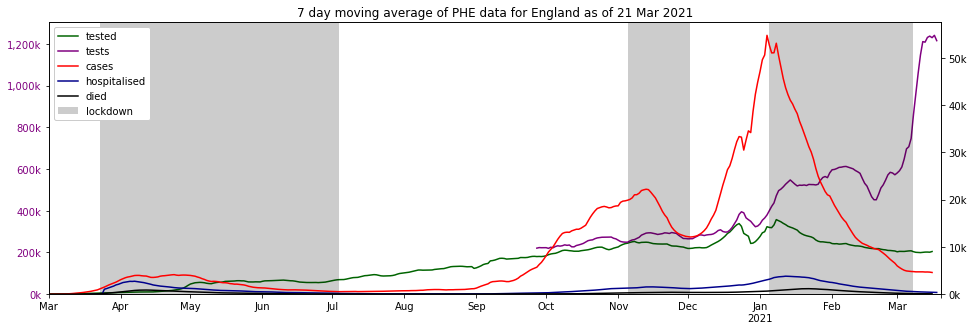

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

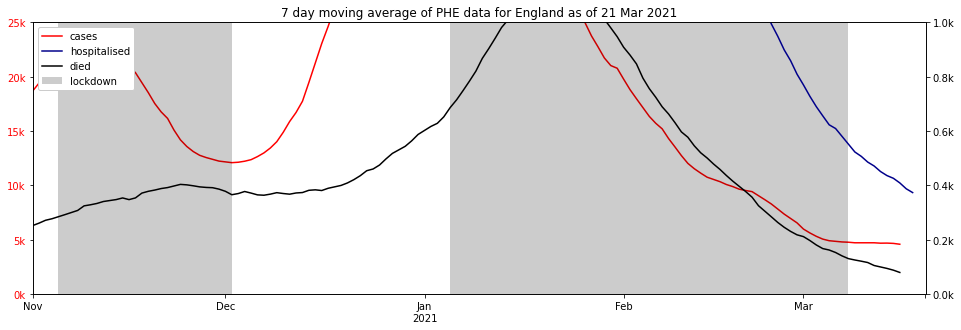

In [3]:
plot_summary(earliest_date='2020-11-01',
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=25_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=1_000)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,1591129.0,23559503.0,21968374.0,56286961,2.826816,39.029242,58.143942
1,Northern Ireland,N92000002,78496.0,667758.0,589262.0,1893667,4.145185,31.117509,64.737306
2,Scotland,S92000003,220188.0,2144940.0,1924752.0,5463300,4.030311,35.230575,60.739114
3,Wales,W92000004,338959.0,1258769.0,919810.0,3152879,10.750777,29.173654,60.075569


'partial: 27,630,970 (41.4%), full: 2,228,772'

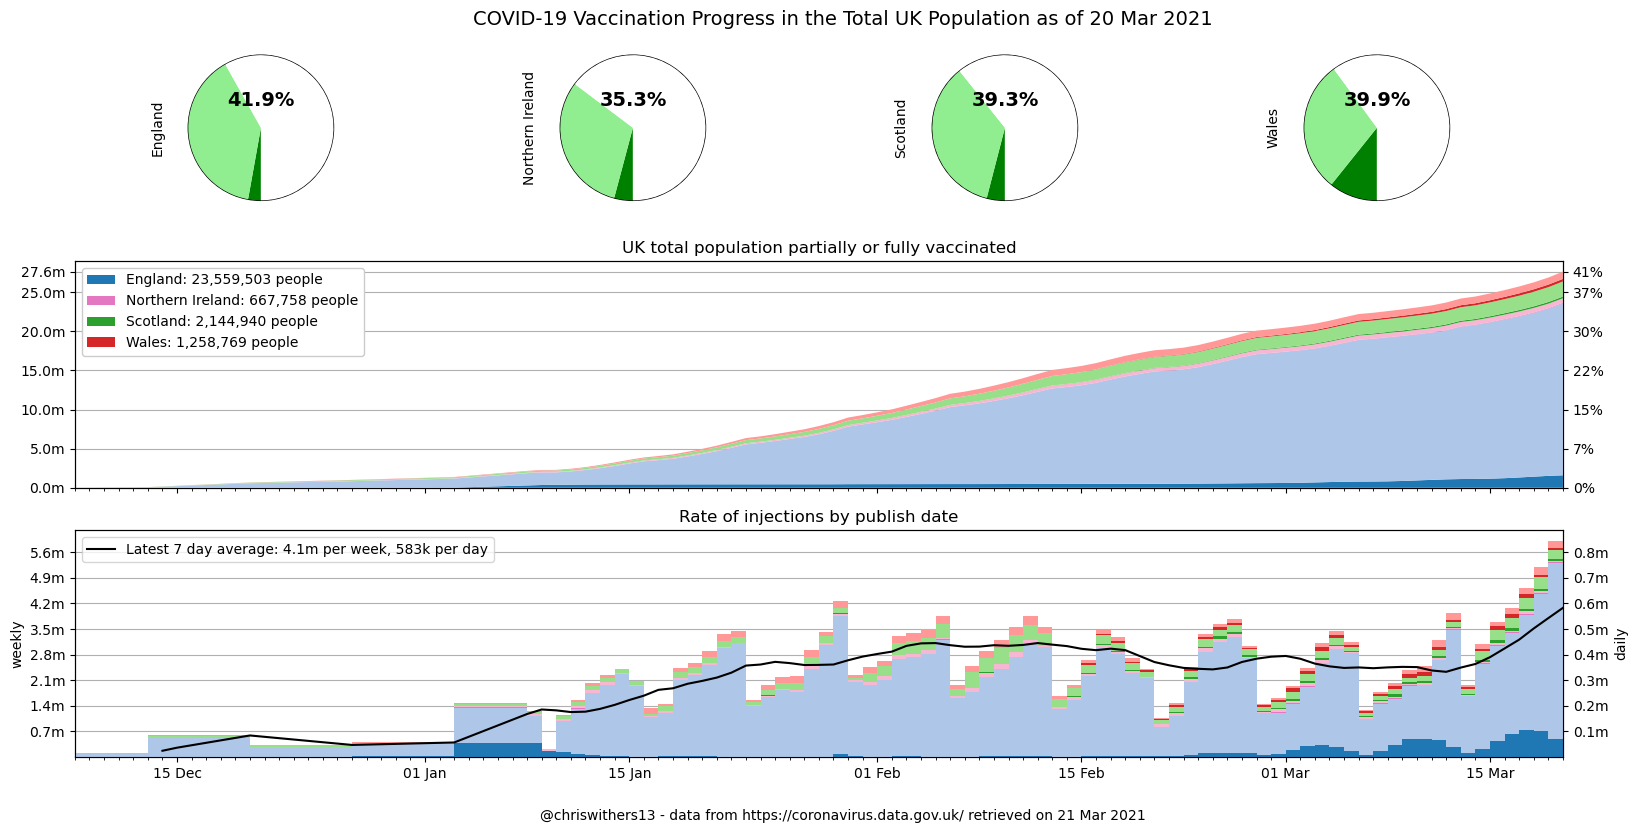

In [4]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

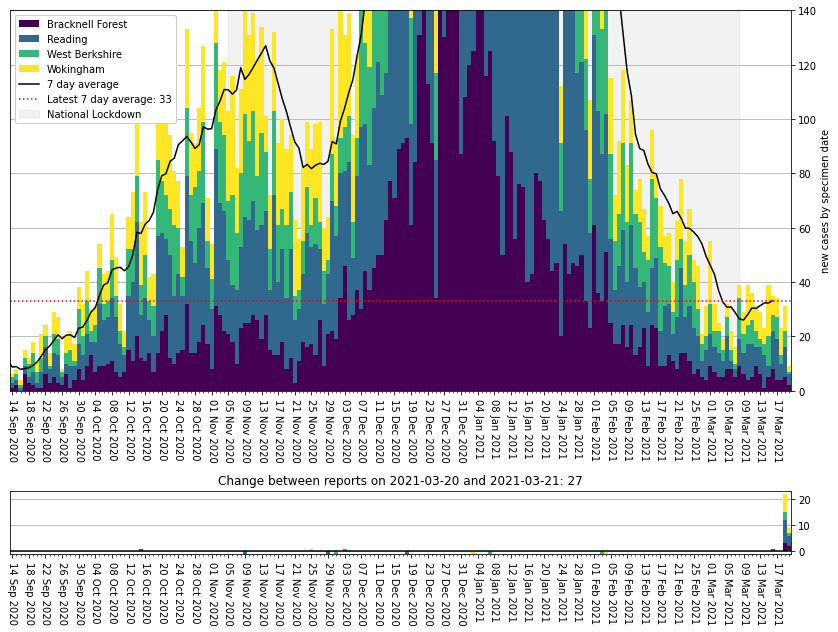

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=140, show_testing=False)

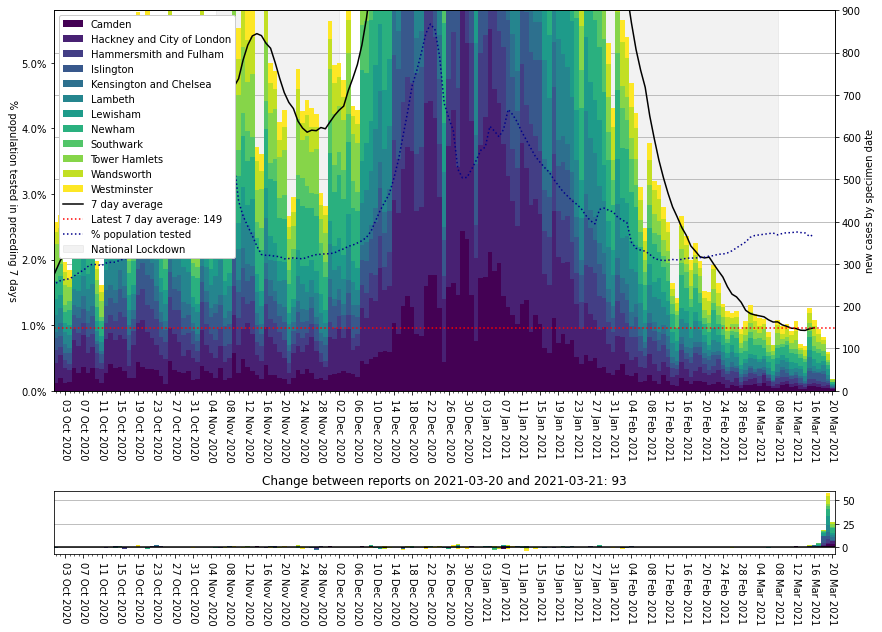

In [7]:
plot_areas(for_date, areas=london_areas, ylim=900)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000040,West Lothian,191.152376,350.0,2021-03-20
E07000150,Corby,178.625827,129.0,2021-03-20
E08000016,Barnsley,164.056614,405.0,2021-03-20
E07000236,Redditch,154.818733,132.0,2021-03-20
E06000013,North Lincolnshire,145.102500,250.0,2021-03-20
E06000010,"Kingston upon Hull, City of",134.730424,350.0,2021-03-20
E08000018,Rotherham,127.726432,339.0,2021-03-20
E08000032,Bradford,124.310825,671.0,2021-03-20
E06000032,Luton,122.505304,261.0,2021-03-20


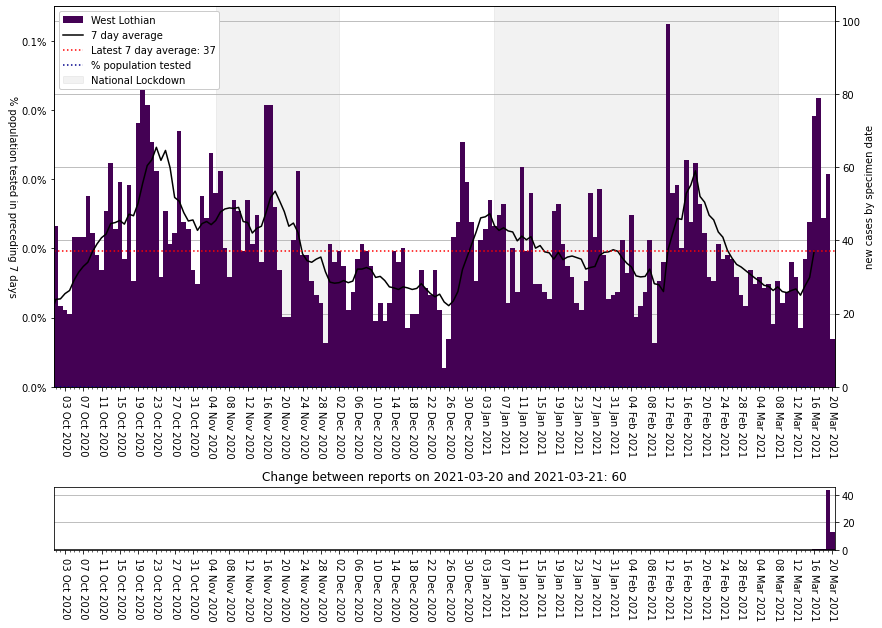

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,64.809041,740.0,2021-03-20
E08000035,Leeds,87.500426,694.0,2021-03-20
E08000032,Bradford,124.310825,671.0,2021-03-20
S12000049,Glasgow City,100.770786,638.0,2021-03-20
E08000019,Sheffield,104.299713,610.0,2021-03-20
E08000034,Kirklees,93.909097,413.0,2021-03-20
E08000003,Manchester,73.798335,408.0,2021-03-20
E08000036,Wakefield,117.136361,408.0,2021-03-20
E08000016,Barnsley,164.056614,405.0,2021-03-20


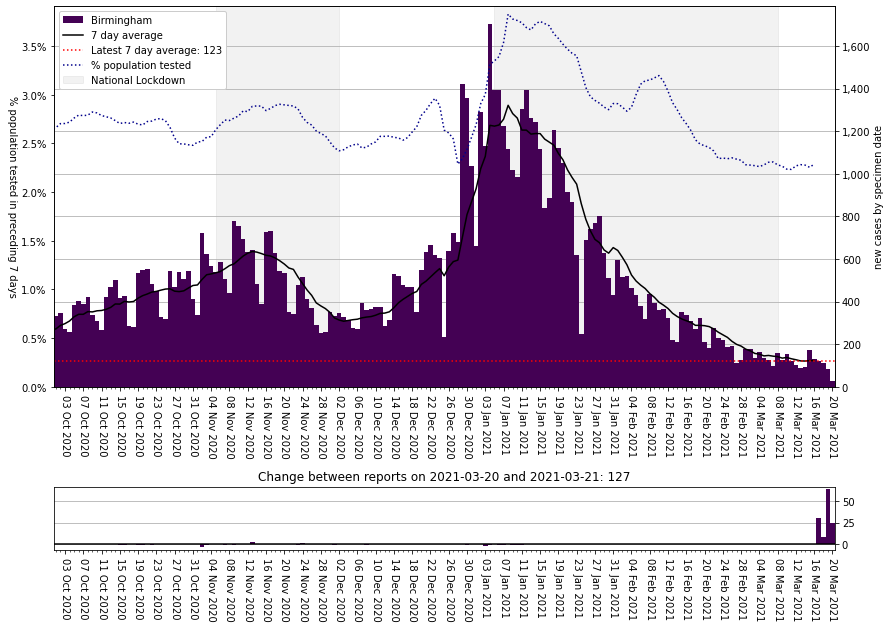

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.2

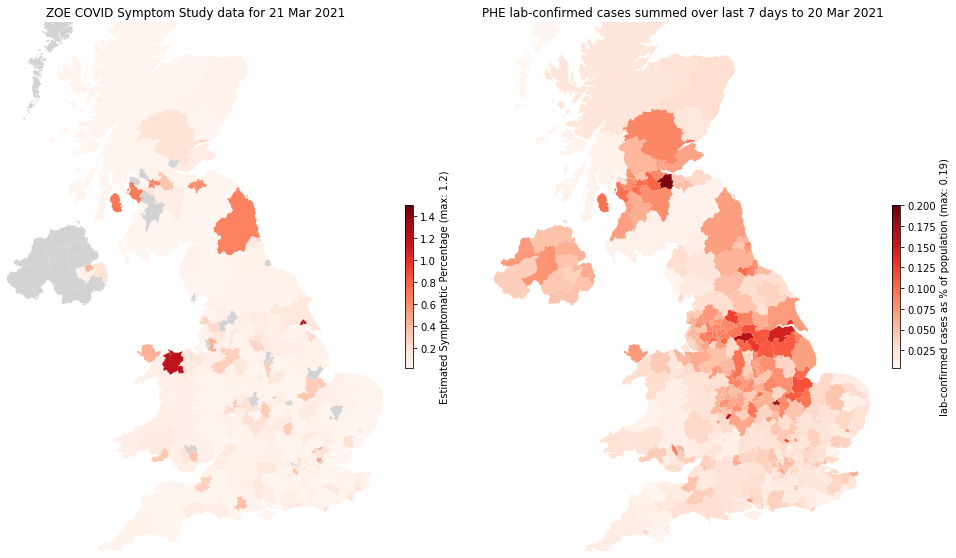

In [14]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [15]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

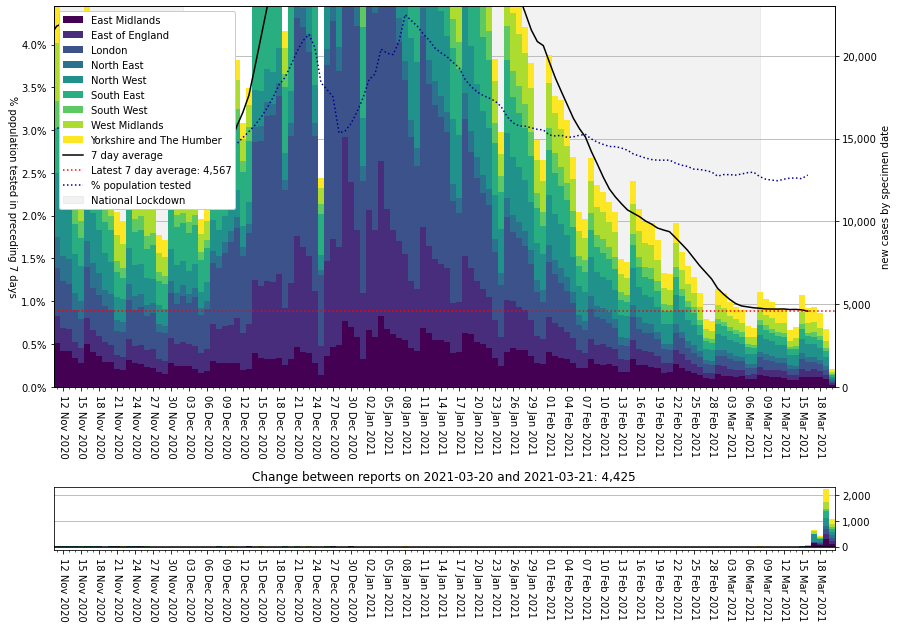

In [16]:
plot_areas(for_date, area_type=region, ylim=23_000, earliest='2020-11-11')

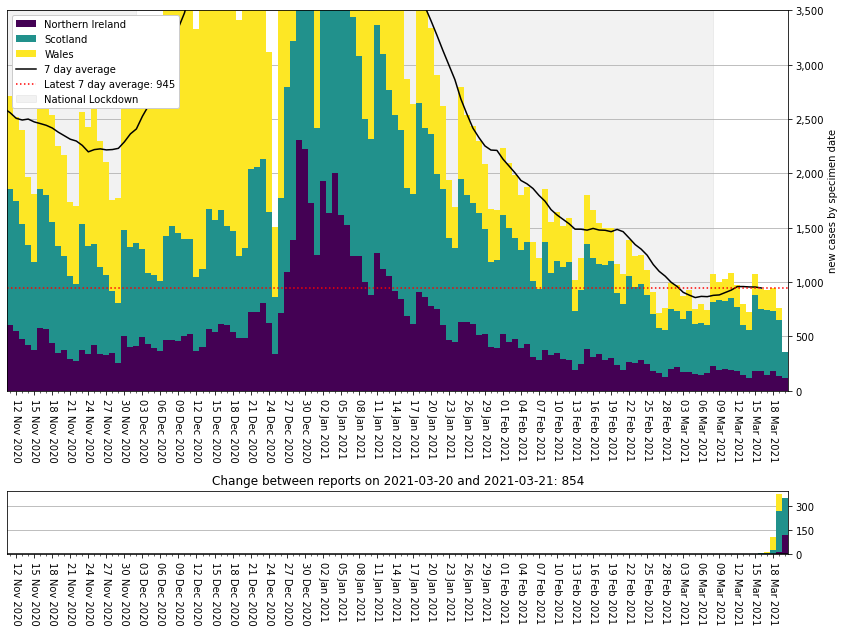

In [17]:
plot_areas(for_date, 'cases_devolved', ylim=3_500, diff_ylims=None, earliest='2020-11-11')